## Simple shear experiment

The primary goal of this notebook is to demonstrate the formation of shear bands as a function of accumulating shear strain in a model with a softening frictional rheology. It also shows some strategies for visualising the shear bands.

We consider a periodic domain with plastic-strain-softening, Drucker-Prager rheology which is subject to simple shear boundary conditions (the top and the bottom of the domain are driven at constant velocity in opposite directions.

The rheology is described by:

\begin{equation}
    \eta =  
        \begin{cases}
              \eta_0 & |\tau| < \tau_\textrm{yield} \\
              {\tau_\textrm{yield}} / {2 \left| \, \dot\varepsilon \, \right|} & \textrm{otherwise}
        \end{cases}
\end{equation}
where the yield stress, $\tau_\textrm{yield}$ is given by

\begin{equation}
    \tau_\textrm{yield} = C(\varepsilon_p) + \mu p 
\end{equation}

$ \left| \, \dot\varepsilon \, \right| $ is the second invariant of the strain rate tensor, $\varepsilon$ is its integral over time in regions where the yield stress is reached, $C$ is a cohesion, $\mu$ is a friction coefficient, and $p$ is the pressure.

The cohesion weakens with accumulated plastic strain as follows:

\begin{equation}
    C = c_0 + c_1 e^{ \left( -\varepsilon_\textrm{p} / \varepsilon_0 \right)}
\end{equation}

No healing of the cohesion is implemented in this example.




In [1]:
# %matplotlib inline
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
import numpy as np
import math
import os

import underworld as uw
from underworld import function as fn
from underworld import meshvariable as meshvariable
import glucifer

In [2]:
# As a precaution ... keep workdir. Something in uw is cd'ing to crazy places within the python installation. 
# It seems to be gLucifer.

try:
    workdir
except NameError:
    workdir = os.path.abspath(".")
     
outputPath = os.path.join(workdir,"SimpleShear2D/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    

Create mesh and finite element variables
------

Note: the use of a pressure-sensitive rheology suggests that it is important to use a Q2/dQ1 element 

In [3]:
minX = 0.0
maxX = 4.0

resX = 192
resY = 48
elementType="Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, 0.), 
                                 maxCoord    = ( maxX, 1.),
                                 periodic    = [True, False]  ) 


velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

### Boundary conditions

Simple shear with periodic (wrap-around) walls in the _x_ direction

In [4]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

#velocityField.data[mesh.specialSets["MinJ_VertexSet"]] = 0.
for index in mesh.specialSets["MinJ_VertexSet"]:
    velocityField.data[index] = [-0.5, 0.]
for index in mesh.specialSets["MaxJ_VertexSet"]:
    velocityField.data[index] = [0.5, 0.]
    
periodicBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = ( jWalls, jWalls) ) 

### Setup the material swarm

This is used for tracking deformation and history dependence of the rheology

In [5]:
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout   = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=10 )
swarm.populate_using_layout( layout=swarmLayout )

deformationSwarm = uw.swarm.Swarm ( mesh=mesh )

### Create a particle advection system

Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).

In [6]:
advector        = uw.systems.SwarmAdvector( swarm=swarm,        velocityField=velocityField, order=2 )
advector2       = uw.systems.SwarmAdvector( swarm=deformationSwarm, velocityField=velocityField, order=1 )

### Add swarm variables

We are using a single material with a single rheology. We need to track the plastic strain in order to have some manner of strain-related softening (e.g. of the cohesion or the friction coefficient). For visualisation of swarm data we need an actual swarm variable and not just the computation.

Other variables are used to track deformation in the shear band etc.

**NOTE**:  Underworld needs all the swarm variables defined before they are initialised or there will be / can be memory problems (at least it complains about them !). That means we need to add the monitoring variables now, even if we don't always need them.

In [7]:
plasticStrain  = swarm.add_variable( dataType="double",  count=1 )

# Plastic strain- initialise with a small random perturbation which is 
# concentrated in the centre of the domain (see below)


deformationVariable = deformationSwarm.add_variable( dataType="double", count=1)



### Initialise swarm variables



In [8]:

# plastic strain - random initial value with an envelope to ensure the 
# localisation stays clear of the boundary = the same function will be used
# later to suppress the plastic strain weakening close to the boundaries. 

def boundary(xx, width, power):
    return (np.tanh(xx*width) + np.tanh((1.0-xx)*width) - math.tanh(width))**power

weight = boundary(swarm.particleCoordinates.data[:,1], 10, 4)

plasticStrain.data[:] = 0.05 * np.random.rand(*plasticStrain.data.shape[:])
plasticStrain.data[:,0] *= weight


deformationPoints = np.array(np.meshgrid(np.linspace(minX+0.01, maxX-0.01, 50), np.linspace(0.1, 0.8, 100))).T.reshape(-1,2)
deformationSwarm.add_particles_with_coordinates( deformationPoints )


array([   0,    1,    2, ..., 4997, 4998, 4999], dtype=int32)

### Define the viscosity function

In this case, the viscosity of material which has not reached the yield criterion is simply going to be a constant. Nevertheless, it is useful to define it here as a function and write the remaining code such that it is not changed if we introduce additional materials or a dependence on another set of equations.



In [9]:
viscosity0  = 1.0

backgroundViscosityFn = fn.misc.constant(viscosity0)

### Define a yield criterion (function)

\begin{equation}
    \tau_\textrm{yield} = C(\varepsilon_p) + \mu p 
\end{equation}

The yield strength described above needs to be evaluated on the fly at the particles (integration points). It therefore needs to be a function composed of mesh variables, swarm variables, constants, and mathematical operations.


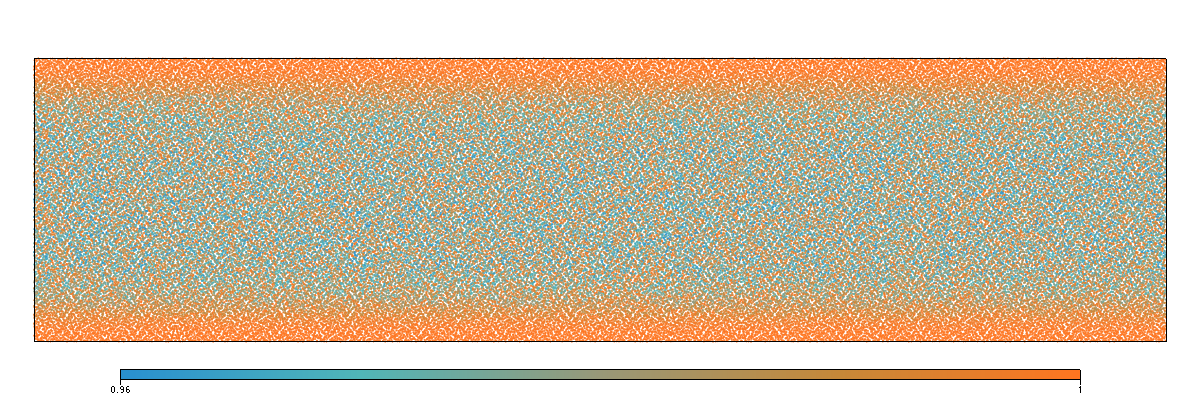

In [10]:
# Friction - in this form it could also be made to weaken with strain

frictionInf     = fn.misc.constant(0.5)
frictionFn      = frictionInf 

# Cohesion - a function of swarm variables

cohesionInf     = fn.misc.constant(0.25)
cohesion0       = fn.misc.constant(0.75)
referenceStrain = fn.misc.constant(1.0)

cohesionFn =  cohesionInf + cohesion0 * fn.math.exp(-plasticStrain / referenceStrain )


# Drucker-Prager yield criterion

yieldStressFn   = cohesionFn + frictionFn * pressureField


# Plot it and see (it will be the cohesion in the first run through) 

figYieldStress = glucifer.Figure( figsize=(1200,400) )
figYieldStress.append( glucifer.objects.Points(swarm, yieldStressFn , pointSize=3.0) )
figYieldStress.show()


### Define composite (yielding) rheology

The actual constitutive behaviour is a composite of the behaviour below the yield strength and the reduced viscosity required to ensure that the stress remains bounded by the yield envelope.

\begin{equation}
    \eta =  
        \begin{cases}
              \eta_0 & |\tau| < \tau_\textrm{yield} \\
              {\tau _ \textrm{yield}} / {2 \left| \, \dot\varepsilon \, \right|} & \textrm{otherwise}
        \end{cases}
\end{equation}

**Note**: The $1.0^{-18}$ added to the strain-rate is supposed to be a small number preventing the rheology from blowing up if the velocity field is zero. Obviously this number should be much smaller than the expected strain rate !

In [11]:
# first define strain rate tensor

strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

# now compute a viscosity assuming yielding

min_viscosity = 0.01

yieldingViscosityFn =  0.5 * yieldStressFn / (strainRate_2ndInvariantFn+1.0e-18)

viscosityFn = fn.exception.SafeMaths( fn.misc.max(fn.misc.min(yieldingViscosityFn, 
                                                              backgroundViscosityFn), 
                                                  min_viscosity))


### Deviatoric stress 

The deviatoric stress is computed from the constitutive law based on the viscosity that
results from the solution to the non-linear Stokes equation.

**Note:** the deviatoric stress is defined in terms of functions we have defined already
but the value will be meaningless if the viscosityFn is modified in any way after the 
solve is complete because evaluation is made only when the values at particular points are needed.

In [12]:

# DeviatoricStress

devStressFn = 2.0 * viscosityFn * strainRateFn

### Buoyancy forces

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [13]:
# buoyancy force term (not used in this geometry)

z_hat   = ( 0.0, 0.0 )
buoyancyFn = z_hat 

System setup
-----

Setup a Stokes equation system and connect a solver up to it.  

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [14]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               swarm         = swarm, 
                               conditions    = [periodicBC,],
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = None )


solver = uw.systems.Solver( stokesPIC )

solver.set_inner_method("lu")
solver.set_penalty(1.0e6)
solver.options.scr.ksp_rtol = 1.0e-3

stokesPIC.fn_viscosity = viscosityFn
solver.solve( nonLinearIterate=True )



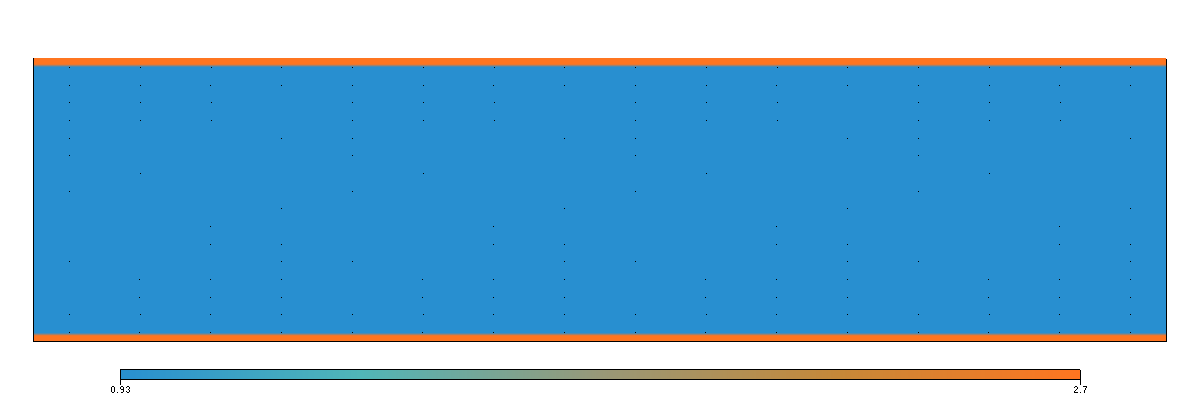

In [15]:
velocityFieldAnomaly = velocityField.copy()
velocityFieldAnomaly = velocityField - ( 1.0, 0.0 ) * (fn.input()[1] - 0.5)

curlV = velocityField.fn_gradient[1] - velocityField.fn_gradient[2]

figStrainRate2 = glucifer.Figure(figsize=(1200, 400))
figStrainRate2.append( glucifer.objects.VectorArrows(mesh, velocityFieldAnomaly, scaling=.1) )
figStrainRate2.append( glucifer.objects.Surface(mesh, curlV) )
figStrainRate2.show()


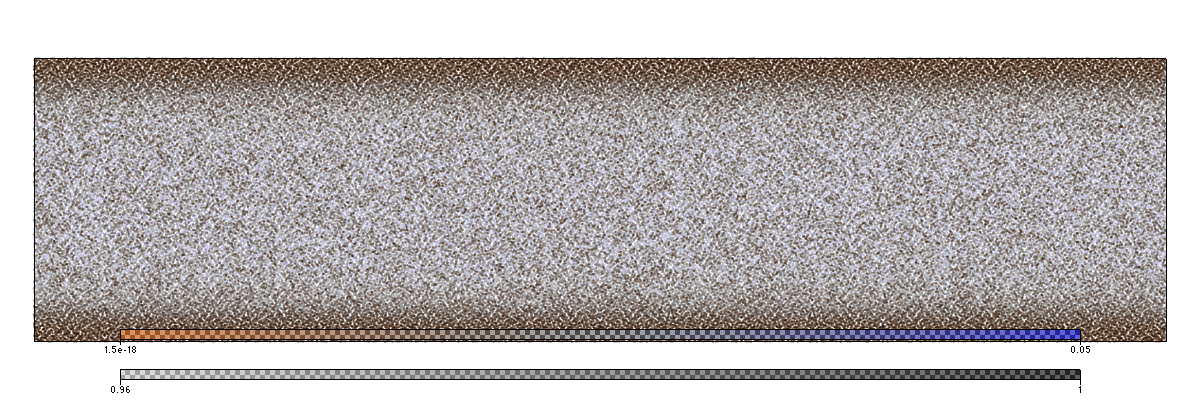

In [16]:
figStrain = glucifer.Figure( figsize=(1200, 400))
figStrain.append( glucifer.objects.Points(swarm, cohesionFn, pointSize=5.0, colours="white:0.5 black:0.5") )
figStrain.append( glucifer.objects.Points(swarm, plasticStrain, pointSize=4.0,  colours="#FF6600:0.5, #555555:0.25, Blue:0.5") )
figStrain.show()

## Main simulation loop
-----

In [17]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0
nsteps = 100

while step<nsteps:
    solver.solve( nonLinearIterate=True )

    dt = advector.get_max_dt()
    advector.integrate(dt)
    advector2.integrate(dt)
                      
    swarmViscosity = viscosityFn.evaluate(swarm)
    swarmStrainRateInv = strainRate_2ndInvariantFn.evaluate(swarm)

    weight = boundary(swarm.particleCoordinates.data[:,1], 10, 4)
    plasticStrainIncrement = dt * np.where( swarmViscosity < viscosity0, swarmStrainRateInv , 0.0 )
    plasticStrainIncrement[:,0] *= weight
    plasticStrain.data[:] += plasticStrainIncrement

    if (step%5 ==0):
       
        figStrainRate2.save_image(     outputPath + "figStrainRate-" +str(frictionInf.evaluate([0.0,0.0])[0])+"-" + str(step).zfill(4))
        
        figYieldStress.save_image(      outputPath + "figStrength-"     +str(frictionInf.evaluate([0.0,0.0])[0])+"-" + str(step).zfill(4))

      
    if uw.rank()==0:
        print('step = {0:6d}; time = {1:.3e};'.format(step,time))
        print("Plastic Strain - max = {}".format(plasticStrain.evaluate(swarm).max()))

    time += dt
    step += 1

step =      0; time = 0.000e+00;
Plastic Strain - max = 0.049957174129
step =      1; time = 2.083e-02;
Plastic Strain - max = 0.049957174129
step =      2; time = 4.167e-02;
Plastic Strain - max = 0.049957174129
step =      3; time = 6.250e-02;
Plastic Strain - max = 0.060002298977


KeyboardInterrupt: 

Post simulation analysis
-----

**Note**: Because `figCohesion` is defined entirely in terms of StGermain functions, it will automatically plot the latest version of the cohesion evaluated at each of the particle locations. This is not true of the figure which has to compute the velocity anomaly. The reason for this is that the function interface does not (yet) have the capacity to manipulate the velocity as required.


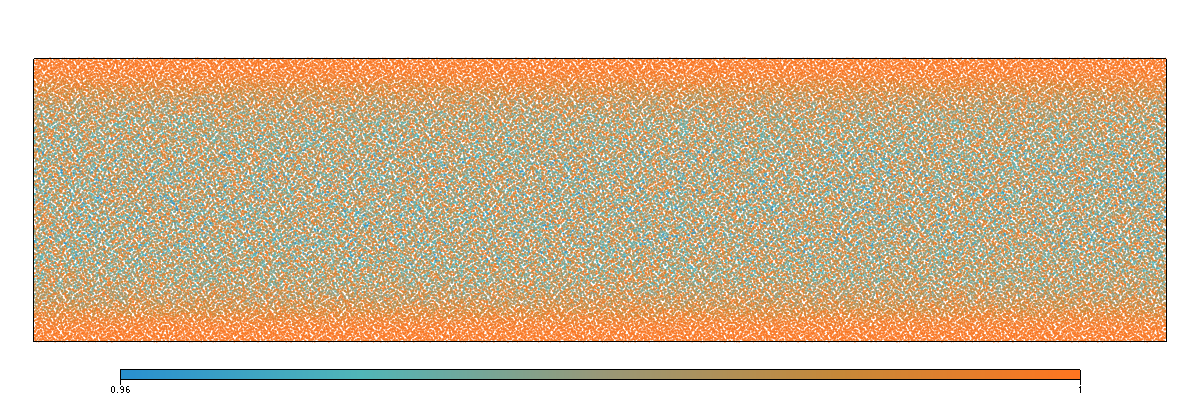

In [18]:
figYieldStress.show()


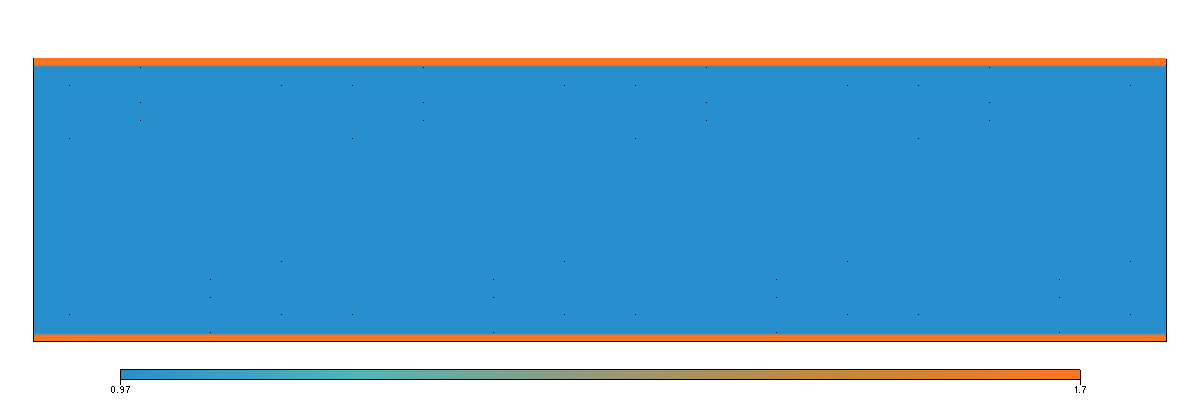

In [19]:
figStrainRate2.show()


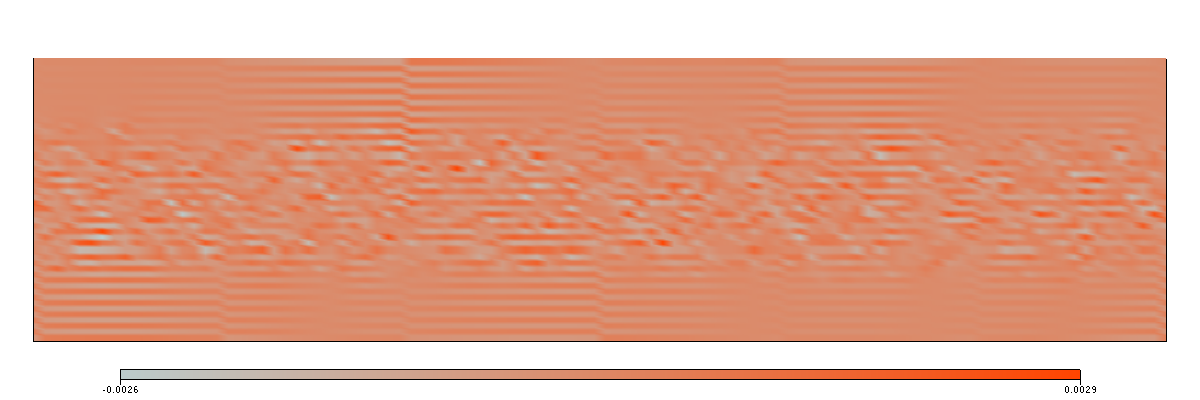

In [20]:
figPressure = glucifer.Figure(figsize=(1200, 400))
figPressure.append( glucifer.objects.Surface(mesh, pressureField, colours="#BBCCCC, #FF4400") )
figPressure.show()